In [7]:
import pandas as pd
import seaborn as sns
import sys
import matplotlib.pyplot as plt
from sklearn import linear_model

sys.path.append("..")

from utils import get_def_player_stats, get_players_info

In [ ]:
# PRIMARY PREPROCESSING CELL
# --------------------------
de_df = get_def_player_stats(list(range(1999, 2025)))

# I only care about defensive ends during the regular season
# Post seasons stats would skew things
de_df = de_df[(de_df["position"] == "DE") & (de_df["season_type"] == "REG")]

de_df = de_df.rename(columns={"week": "games"})

# Add some players specific information
players_df = get_players_info()
de_df["birth_date"] = de_df["player_id"].map(
    players_df.set_index("gsis_id")["birth_date"], na_action="ignore"
)


# Anyone missing a birth date probably isn't in the stats anyways but let's filter out
de_df = de_df[de_df["birth_date"].notna()]

# Calculate the estimated age for each season. Could consider doing this by week
de_df["age"] = de_df["season"] - pd.DatetimeIndex(de_df["birth_date"]).year

# Only use columns I care about
de_df = de_df[
    [
        "player_id",
        "season",
        "games",
        "player_display_name",
        "def_sacks",
        "age",
    ]
]

de_df = de_df.groupby(["player_id", "season"]).agg(
    {
        "player_display_name": "max",
        "age": "max",
        "games": "count",
        "def_sacks": "sum",
    }
)
# populate some previous season stats to compare
g = de_df.sort_values(["season"]).groupby(["player_id", "season"])["def_sacks"].sum()
joined = (
    g.to_frame()
    .assign(current_sacks=g)
    .join(g.groupby(level=[0]).shift().to_frame(), lsuffix="", rsuffix="_")
    .rename(columns={"def_sacks_": "previous_sacks"})
)
joined.update(
    joined[["current_sacks", "previous_sacks"]].mask(
        joined["previous_sacks"].isna()
        | joined["previous_sacks"].eq(joined["current_sacks"]),
        "",
    )
)
de_df["previous_sacks"] = joined["previous_sacks"]

g = de_df.sort_values(["season"]).groupby(["player_id", "season"])["games"].sum()
joined = (
    g.to_frame()
    .join(g.groupby(level=[0]).shift().to_frame(), lsuffix="", rsuffix="_")
    .rename(columns={"games_": "previous_games"})
)
joined.update(
    joined[["games", "previous_games"]].mask(
        joined["previous_games"].isna() | joined["previous_games"].eq(joined["games"]),
        "",
    )
)
de_df["previous_games"] = joined["previous_games"]

(36672, 32)
(36672, 34)
(3580, 6)


(2056, 9)


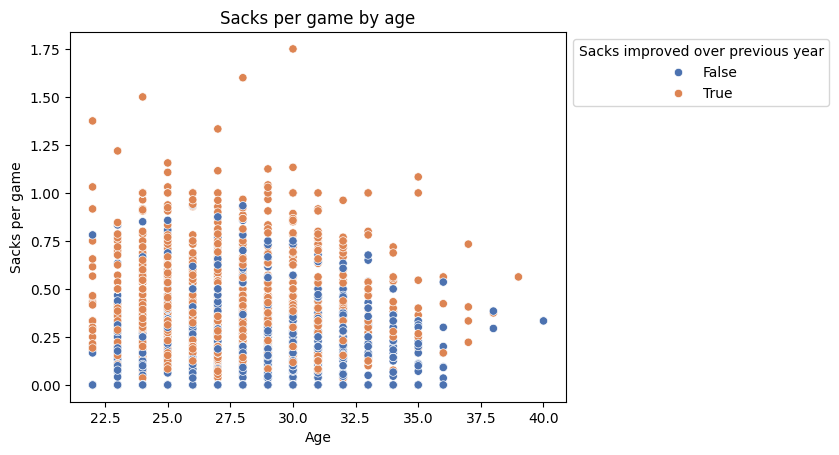

In [42]:
# Visualize

# Drop first year for each player
clean_df = de_df[(de_df['previous_sacks'] != '') & (de_df['previous_games'] != '')].astype({'previous_sacks': 'int32', 'previous_games': 'int32'})
clean_df = clean_df.eval('sacks_pg = def_sacks / games')
clean_df = clean_df.eval('previous_sacks_pg = previous_sacks / previous_games')
clean_df = clean_df.eval('sacks_pg_diff = sacks_pg - previous_sacks_pg')
print(clean_df.shape)

labels = ['No', 'Yes']
sacks_pg_improved = clean_df.eval("sacks_pg_diff > 0").rename("sacks_pg_positive")
ax = sns.scatterplot(x='age', y='sacks_pg', data=clean_df, hue=sacks_pg_improved, palette="deep")

ax.set_title("Sacks per game by age")
ax.legend(title="Sacks improved over previous year")
ax.set_ylabel("Sacks per game")
ax.set_xlabel("Age")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))